## Задача: предсказание победы по данным о первых 5 минутах игры

По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?

Признаки, представленные в таблице `features.csv`, по мнению экспертов в предметной области являются наиболее важными для решения задачи предсказания победы команды.

## Метрика качества

В качестве метрики качества мы будем использовать площадь под ROC-кривой (AUC-ROC). Обратите внимание, что AUC-ROC — это метрика качества для алгоритма, выдающего оценки принадлежности первому классу. Оба алгоритма, которые будут использоваться в проекте — градиентный бустинг, и логистическая регрессия — умеют выдавать такие оценки.Функция предсказания возвращает два столбца: первый содержит оценки принадлежности нулевому классу, второй — первому классу.

Необходимо провести описанные ниже два этапа исследования, написать по результатам каждого этапа небольшой отчет (ниже указаны вопросы, ответы на которые должны содержаться в отчете), и предоставить для ревью данный отчет и код, с помощью которого вы выполнили задание.

**Обратите внимание:** высокое качество работы на кросс-валидации (близкое к 100%) — это в первую очередь повод задуматься о том, правильно ли вы обучаете модель. Возможно, вы заглядываете в будущее или настраиваетесь на неправильном наборе признаков.

**Подход 1: градиентный бустинг "в лоб"**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
features = pd.read_csv('features.csv', index_col='match_id')
features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
features1 = features.drop(['duration','radiant_win', 'tower_status_radiant',
                           'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis = 1)

In [4]:
# Проверка выборки на наличие пропусков 

In [5]:
features1.columns[features1.isna().sum()>0]

Index(['first_blood_time', 'first_blood_team', 'first_blood_player1',
       'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time',
       'radiant_flying_courier_time', 'radiant_first_ward_time',
       'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
       'dire_first_ward_time'],
      dtype='object')

In [6]:
missing = features1.isna().sum()
missing[missing > 0]

first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64

In [7]:
# Замена пропусков на нули

In [8]:
features1.fillna(0, inplace = True)

In [9]:
missing = features1.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

**Попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируем генератор разбиений для кросс-валидации по 5 блокам (KFold), перемешаем при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества.** 

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [11]:
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

X = features1
y = features['radiant_win']

Оценим качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуем при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30) 

In [12]:
import time
import datetime

for i in range(10, 71, 10):
    start_time = datetime.datetime.now()
    gb = GradientBoostingClassifier(n_estimators = i, random_state=42)
    quality = cross_val_score(gb, X, y, cv=kf5, scoring='roc_auc')
    q = np.mean(quality)
    print(i, q)
    print ('Time elapsed:', datetime.datetime.now() - start_time)

10 0.6648506879750012
Time elapsed: 0:00:38.152238
20 0.6824618768044435
Time elapsed: 0:01:12.588690
30 0.6900064710388155
Time elapsed: 0:01:54.495677
40 0.6940387245121105
Time elapsed: 0:02:26.405627
50 0.6974943609466162
Time elapsed: 0:02:49.586962
60 0.7001193156741052
Time elapsed: 0:03:43.105799
70 0.7021165414535407
Time elapsed: 0:04:11.620156


Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

В наблюдаемом диапазоне качество продолжает расти, но совсем незначительно

### Отчет

**Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?**
'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time','dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time','dire_first_ward_time'

Например признаки события "первая кровь" (first blood) принимают пропущенное значения если событие "первая кровь" не успело произойти за первые 5 минут.

**Как называется столбец, содержащий целевую переменную?**

'radiant_win'

**Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями?** 

Time elapsed: 0:00:44.161785

**Какое качество при этом получилось?**

0.6900064710388155

**Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге?** 

Имеет смысл использовать 40-50 деревьев, далее значительно увеличивается время обучения модели, качество при этом увеличивается незначительно.

**Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?**

Обучать модель на подмножестве выборки или варьировать параметры алгоритма

**Подход 2: логистическая регрессия**

In [13]:
X = features1
y = features['radiant_win']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

Оценим качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберем при этом лучший параметр регуляризации (C).

In [14]:
from sklearn.linear_model import LogisticRegression
max = 0

In [15]:
for i in np.arange(0.1, 10, 0.5):
    start_time = datetime.datetime.now()
    logreg = LogisticRegression(penalty = 'l2', C = i, random_state = 42, solver='lbfgs')
    quality = cross_val_score(logreg, X_scaled, y, cv=kf5, scoring='roc_auc')
    q = np.mean(quality)
    if q > max:
        max = q
        print(i, max)
        print ('Time elapsed:', datetime.datetime.now() - start_time)

0.1 0.7165269451581027
Time elapsed: 0:00:03.963502


Качество лучше чем у градиентного бустинга  
Модель лог.регрессии лучше воспринимает данные
Логистическая регрессия работает быстрее по сравнению с градиентным бустингом

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберем их из выборки, и проведем кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

In [16]:
X1 = X.drop(['lobby_type', 'r1_hero', 'r2_hero','r3_hero','r4_hero','r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero'], axis =1 )

scaler1 = StandardScaler()

X_scaled1 = scaler.fit_transform(X1)

In [17]:
max = 0

for i in np.arange(0.1, 10, 0.5):
    start_time = datetime.datetime.now()
    logreg = LogisticRegression(penalty = 'l2', C = i, random_state = 42, solver='lbfgs')
    quality = cross_val_score(logreg, X_scaled1, y, cv=kf5, scoring='roc_auc')
    q = np.mean(quality)
    if q > max:
        max = q
        print(i, max)
        print ('Time elapsed:', datetime.datetime.now() - start_time)

0.1 0.7165338144534041
Time elapsed: 0:00:02.727023


Качество увеличилось,т.к. категориальные атрибуты неправильно воспринимались.

На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясним из данных, сколько различных идентификаторов героев существует в данной игре

In [18]:
s = 0
list = ['r1_hero', 'r2_hero','r3_hero','r4_hero','r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
features = pd.read_csv('features.csv', index_col='match_id')

for i in list:
    k = features[i].nunique()
    if s!= k:
        s = k
        print(s)

108


In [19]:
np.max(features['r1_hero'])

112

Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Добавим полученные признаки к числовым, которые мы использовали во втором пункте данного этапа.

In [21]:
X_pick = np.zeros((X.shape[0], 112))

for i, match_id in enumerate(X.index):
    for p in range(5):
        X_pick[i, X.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [22]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [23]:
X_final=np.hstack((X_scaled,X_pick))

Проведем кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации

In [24]:
max = 0

for i in np.arange(0.1, 10, 0.8):
    start_time = datetime.datetime.now()
    logreg = LogisticRegression(penalty = 'l2', C = i, random_state = 42, solver='lbfgs', max_iter = 10000)
    quality = cross_val_score(logreg, X_final, y, cv=kf5, scoring='roc_auc')
    q = np.mean(quality)
    if q > max:
        max = q
        print(i, max)
        print ('Time elapsed:', datetime.datetime.now() - start_time)

0.1 0.7518995358203323
Time elapsed: 0:00:13.192131


0.7518995379428086, качество улучшилось из-за добавления новых признаков

Построим предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации).

In [26]:
X_test = pd.read_csv('features_test.csv', index_col='match_id')

X_test.fillna(0, inplace =True)

X_pick_test = np.zeros((X_test.shape[0], 112))

for i, match_id in enumerate(X_test.index):
    for p in range(5):
        X_pick_test[i, X_test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, X_test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_scaled_test = scaler.transform(X_test)

X_final_test=np.hstack((X_scaled_test,X_pick_test))

In [27]:
logreg = LogisticRegression(penalty = 'l2', C = 0.1, random_state = 42)

logreg.fit(X_final, y)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1, random_state=42)

In [28]:
pred = logreg.predict_proba(X_final_test)[:, 1]

Убедимся, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [29]:
pred = pd.DataFrame(pred)

In [30]:
pred.describe()

,0
count,17177.000000
mean,0.517005
std,0.221022
min,0.008636
25%,0.345911
50%,0.522687
75%,0.691053
max,0.996388


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

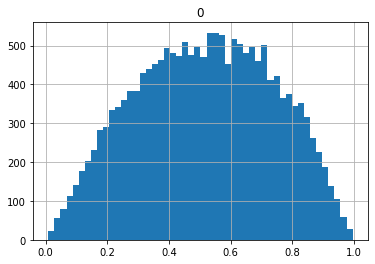

In [31]:
pred.hist(bins=50)

### Отчет

Какое качество получилось у логистической регрессии над всеми исходными признаками? 
0.7165269451581027

Как оно соотносится с качеством градиентного бустинга? 
Качество у лог.рег. лучше чем у градиентного бустинга

Чем вы можете объяснить эту разницу? 
Лог.рег. лучше воспринимает входные данные

Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
Да, быстрее

Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)?
0.7165338144534041

Чем вы можете объяснить это изменение?
Качество улучшилось из-за удаления неправильно воспринимаемых признаков

Сколько различных идентификаторов героев существует в данной игре?
108 (максимальный - 112)

Какое получилось качество при добавлении "мешка слов" по героям? 
0.7518995379428086

Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
Улучшилось т.к. добавились новые информативные признаки

Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?
0.008643 и 0.996390